# Transfer Learning with Tensorflow Part 2: Fine-tuning  

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

In [ ]:
!nvidia-smi

Sun Jun 26 16:44:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    31W /  70W |   4884MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
 
 In the previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.  
 So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).  
We've done this for some of the functions we've used previuosly here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-26 16:44:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-26 16:44:55 (62.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note:** If you're running this notebook in Google Colab, when it times our Colab will delete `helper_functions.py` will get deleted. So you'll have to re-download it again

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` adn apply them to our own problem (recognizing images of food).

In [ ]:
# Get 10% of Food101 data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-06-26 16:44:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.250.4.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  46.1MB/s    in 3.5s    

2022-06-26 16:45:00 (46.1 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:
# Create training and test directories path
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode="categorical",
                                                              batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[2.20000000e+01 0.00000000e+00 2.50000000e+01]
   [2.25969391e+01 0.00000000e+00 2.55969391e+01]
   [2.30000000e+01 0.00000000e+00 2.60000000e+01]
   ...
   [2.30000000e+01 0.00000000e+00 2.60000000e+01]
   [2.30000000e+01 0.00000000e+00 2.60000000e+01]
   [2.30000000e+01 0.00000000e+00 2.80000000e+01]]

  [[2.00000000e+01 0.00000000e+00 2.50000000e+01]
   [2.09336739e+01 9.33673680e-01 2.59336739e+01]
   [2.10306129e+01 9.84693944e-01 2.60000000e+01]
   ...
   [2.14285278e+01 7.85736084e-01 2.60000000e+01]
   [2.10000000e+01 1.00000000e+00 2.80000000e+01]
   [2.30000000e+01 0.00000000e+00 2.80000000e+01]]

  [[1.62091827e+01 0.00000000e+00 2.57857132e+01]
   [1.73571434e+01 0.00000000e+00 2.57857132e+01]
   [1.83571434e+01 7.85714149e-01 2.67857132e+01]
   ...
   [1.97857132e+01 2.14285851e-01 2.66632996e+01]
   [2.00000000e+01 0.00000000e+00 2.70000000e+01]
   [2.00000000e+01 0.00000000e+00 2.70000000e+01]]

  ...

  [[2.00000000e+01 0.00000000e+00 2.77857361e+01]
   [2

## Model 0: Building a transfer learning model using the Keras Functionals API 
The sequential API is straight forward, it runs our layers in sequential order. But the functional API gives us more flexibility with our model.

In [ ]:
# 1. Create base model
base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable=False

# 3. Create inputs into our model
inputs= tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNetB0)
# x = tf.keras.layers.exprimental.preprocessing.Rescaling(1/255.0)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="golbal_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output  activation layer
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220626-164505
Epoch 1/5
24/24 [==============================] - 11s 239ms/step - loss: 1.9119 - accuracy: 0.3987 - val_loss: 1.3568 - val_accuracy: 0.7138
Epoch 2/5
24/24 [==============================] - 5s 190ms/step - loss: 1.1658 - accuracy: 0.7307 - val_loss: 0.9418 - val_accuracy: 0.8059
Epoch 3/5
24/24 [==============================] - 5s 187ms/step - loss: 0.8572 - accuracy: 0.7987 - val_loss: 0.7885 - val_accuracy: 0.8092
Epoch 4/5
24/24 [==============================] - 5s 187ms/step - loss: 0.7034 - accuracy: 0.8227 - val_loss: 0.7046 - val_accuracy: 0.8257
Epoch 5/5
24/24 [==============================] - 5s 186ms/step - loss: 0.6195 - accuracy: 0.8467 - val_loss: 0.6320 - val_accuracy: 0.8322


In [ ]:
# Evaluate on test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6190 - accuracy: 0.8408


[0.6190277934074402, 0.8407999873161316]

In [ ]:
# Check the layers in our base model
for idx,layer in enumerate(base_model.layers):
  print(f"{idx} --> {layer}")

0 --> <keras.engine.input_layer.InputLayer object at 0x7fdeaf35c2d0>
1 --> <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fdeaf3610d0>
2 --> <keras.layers.preprocessing.normalization.Normalization object at 0x7fdeaf35c8d0>
3 --> <keras.layers.convolutional.ZeroPadding2D object at 0x7fdeaf26d8d0>
4 --> <keras.layers.convolutional.Conv2D object at 0x7fdea99e8dd0>
5 --> <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdeaf321710>
6 --> <keras.layers.core.activation.Activation object at 0x7fdea99f6bd0>
7 --> <keras.layers.convolutional.DepthwiseConv2D object at 0x7fdea98edf10>
8 --> <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdea98f9ad0>
9 --> <keras.layers.core.activation.Activation object at 0x7fdea98ce9d0>
10 --> <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fdea98ce290>
11 --> <keras.layers.core.reshape.Reshape object at 0x7fdea98c6bd0>
12 --> <keras.layers.convolutional.Conv2D obje

In [ ]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_3 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_3 (Normalization  (None, None, None,   7          ['rescaling_3[0][0]']            
 )                              3)                                                   

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 golbal_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


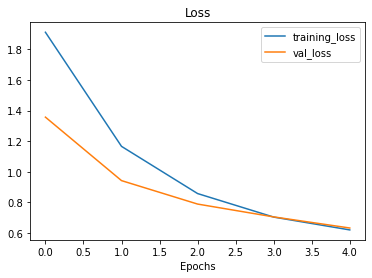

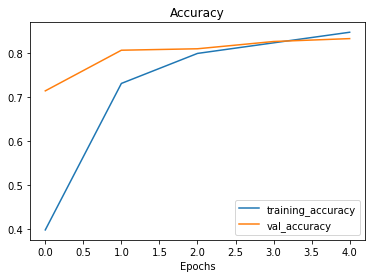

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model 
Let's demonstrate the Global Average Pooling 2D layer...  
We have a tensor after our model goes through `base_model`of shape (None, 7,7,1280).  
But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).  
Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape=(1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

# Pass the random tensors through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooling 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooling 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor,axis=[1,2]).numpy()

array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)

> 🔑**Note:** One of the reasons, feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represent the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of for own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:  
1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data.
> 🔑**Note:** Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2022-06-26 16:45:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   182MB/s    in 0.7s    

2022-06-26 16:45:54 (182 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'

In [ ]:
# Setup data loaders
IMG_SIZE=(224,224)
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=BATCH_SIZE) # default 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                label_mode="categorical",
                                                                image_size=(224,224),
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Add data augmentation right into the model  
To add data augmentation right into our models, we can use the layers inside:  
* `tf.keras.layers.experimental.preprocessing()`  
Benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster).
* Image data augmenation only happens during training, so we can still export our whole model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomZoom,RandomHeight,RandomWidth

# Create data augmentation stage with horizontal flipping, rotations, zooms etc
data_augmentation = keras.Sequential(
    [
     RandomFlip("horizontal"),
     RandomRotation(0.2),
     RandomZoom(0.2),
     RandomHeight(0.2),
     RandomWidth(0.2),
    #  preprocessing.Rescale(1/255.0) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
    ],name="data_augmentation"
)

### Visualize our data augmentation layer

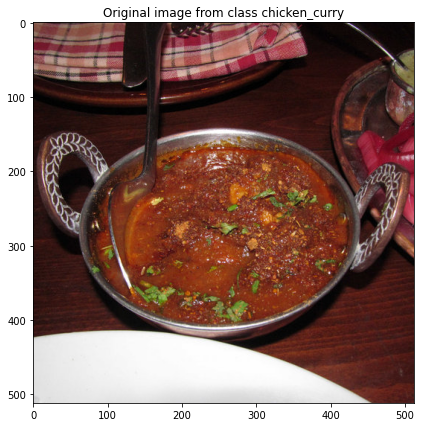

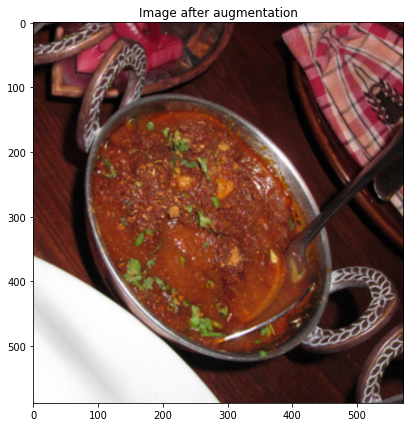

In [ ]:
# View a random image and compare it to aur augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path = target_dir+"/"+random_image

# Read in the random image
img=mpimg.imread(random_image_path)
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.title(f"Original image from class {target_class}")

# Now let's plot our augmented random image
augmented_img=data_augmentation(tf.expand_dims(img,axis=0),training=True)
plt.figure(figsize=(10,7))
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Image after augmentation");

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freesing the base model layers
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# Make a model using the inputs and outputs
model_1=keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent=model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220626-164559
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.3816 - accuracy: 0.0714 - val_loss: 2.2105 - val_accuracy: 0.1628
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1468 - accuracy: 0.3000 - val_loss: 2.1056 - val_accuracy: 0.2500
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9608 - accuracy: 0.4000 - val_loss: 2.0015 - val_accuracy: 0.2961
Epoch 4/5
3/3 [==============================] - 3s 2s/step - loss: 1.8637 - accuracy: 0.4857 - val_loss: 1.8986 - val_accuracy: 0.3750
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.7471 - accuracy: 0.5857 - val_loss: 1.8320 - val_accuracy: 0.3997


In [ ]:
# Check out model summary
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the full test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 1.8373 - accuracy: 0.4144


[1.8372787237167358, 0.41440001130104065]

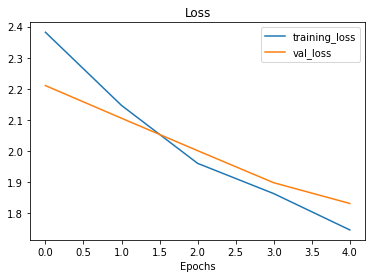

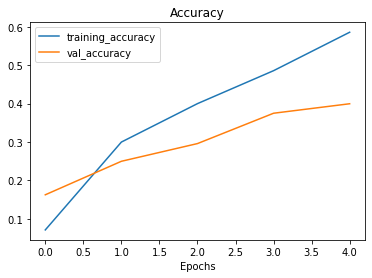

In [ ]:
# How does the model go with data augmentation
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [ ]:
# Get 10% of data
train_dir_10_percent="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [ ]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomRotation,RandomFlip,RandomHeight,RandomWidth,RandomZoom
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential(
    [
     RandomFlip("horizontal"),
     RandomHeight(0.2),
     RandomWidth(0.2),
     RandomZoom(0.2),
     RandomRotation(0.2)
    ],name="data_augmentation"
)

# Setup the input shape to our model
input_shape = (224,224,3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs
inputs = layers.Input(shape=input_shape,name="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs=layers.Dense(10,activation="softmax",name="output_layer")(x)
model_2=tf.keras.Model(inputs,outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a `ModelCheckpoint` callback  

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during the training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path="ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs=5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps = int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220626-164646
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0298 - accuracy: 0.3280
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 376ms/step - loss: 2.0298 - accuracy: 0.3280 - val_loss: 1.5435 - val_accuracy: 0.6546
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3637 - accuracy: 0.6920
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 323ms/step - loss: 1.3637 - accuracy: 0.6920 - val_loss: 1.0688 - val_accuracy: 0.7368
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0725 - accuracy: 0.7187
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 307ms/step - loss: 1.0725 - accuracy: 0.7187 - val_loss: 0.8851 - val_accuracy: 0.7599
Epo

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 74ms/step - loss: 0.6190 - accuracy: 0.8408


[0.619027853012085, 0.8407999873161316]

In [ ]:
original_model_2_results=model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.7104 - accuracy: 0.8016


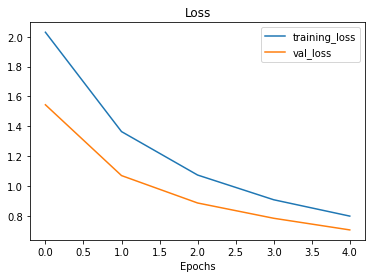

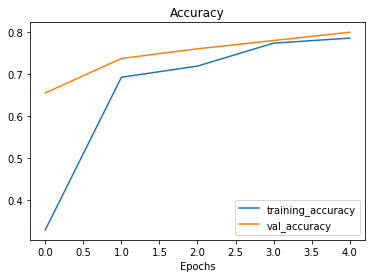

In [ ]:
# Plot loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.7104 - accuracy: 0.8016


In [ ]:
# If the results from our previously evaluated model_2 match the laoded weights, everything has worked!
original_model_2_results==loaded_weights_model_results

False

## Model 3: Fine-tuning an existing model on 10% of the data

> 🔑**Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Layers in our loaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fdea8a27e90> True
<keras.engine.sequential.Sequential object at 0x7fdea8a27a10> True
<keras.engine.functional.Functional object at 0x7fddfb793290> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fdea8a05b10> True
<keras.layers.core.dense.Dense object at 0x7fdeaf3a4c10> True


In [ ]:
for idx,layer in enumerate(model_2.layers[2].layers):
  print(idx,layer.name,layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine-tuning you typically want to lower the learning rate by 10x
                metrics=['accuracy'])

> 🔑**Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much>?This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).

In [ ]:
# Fine tune for another five epochs
fine_tune_epochs=initial_epochs+5

# Refitting the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220626-164759
Epoch 5/10
24/24 [==============================] - 16s 390ms/step - loss: 0.7053 - accuracy: 0.8080 - val_loss: 0.6111 - val_accuracy: 0.7928
Epoch 6/10
24/24 [==============================] - 8s 342ms/step - loss: 0.5725 - accuracy: 0.8213 - val_loss: 0.5317 - val_accuracy: 0.8059
Epoch 7/10
24/24 [==============================] - 7s 284ms/step - loss: 0.5070 - accuracy: 0.8533 - val_loss: 0.5389 - val_accuracy: 0.8109
Epoch 8/10
24/24 [==============================] - 8s 319ms/step - loss: 0.4806 - accuracy: 0.8600 - val_loss: 0.5292 - val_accuracy: 0.8109
Epoch 9/10
24/24 [==============================] - 7s 265ms/step - loss: 0.3987 - accuracy: 0.8787 - val_loss: 0.5199 - val_accuracy: 0.8289
Epoch 10/10
24/24 [==============================] - 8s 308ms/step - loss: 0.3563 - accuracy: 0.8933 - val_loss: 0.5355 - val_accuracy: 0.8158


In [ ]:
# Evaluate the fine-tuned model
results_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.5203 - accuracy: 0.8204


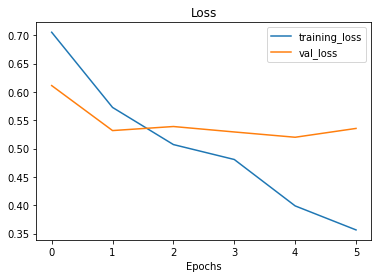

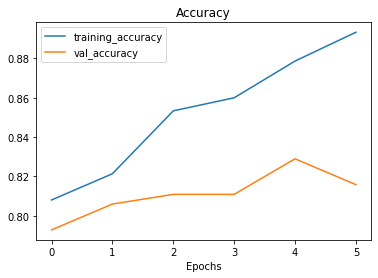

In [ ]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have been only fit once, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history,new_history,initial_epochs=5):
  """
  Compares two TensorFlow History objects
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc=original_history.history["val_accuracy"]
  val_loss=original_history.history["val_loss"]

  # Combine original history
  total_acc=acc+new_history.history["accuracy"]
  total_loss=loss+new_history.history["loss"]
  total_val_acc=val_acc+new_history.history["val_accuracy"]
  total_val_loss=val_loss+new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training Accuracy")
  plt.plot(total_val_acc,label="Val Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine-tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label="Training Loss")
  plt.plot(total_val_loss,label="Val Loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine-tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

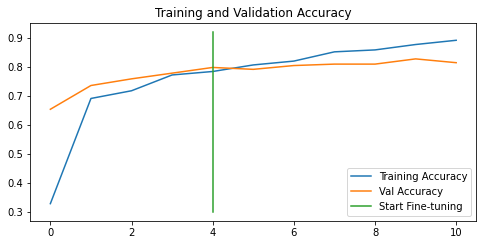

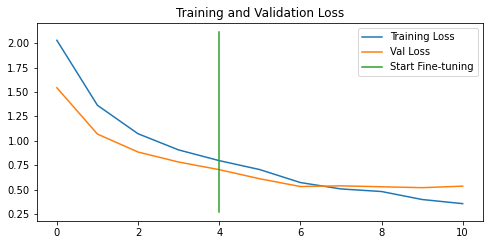

In [ ]:
compare_histories(history_10_percent_data_aug,history_fine_10_percent_data_aug)

## Model 4: Fine-tuning and existing model on all of the data

In [ ]:
# Downlaod and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2022-06-26 17:11:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  55.4MB/s    in 9.7s    

2022-06-26 17:11:14 (51.0 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_classes_full=tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)

test_dir = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).  
Let's verify this...

In [ ]:
# Evaluate model 2 (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 98ms/step - loss: 0.5203 - accuracy: 0.8204


[0.520301878452301, 0.8203999996185303]

In [ ]:
results_fine_tune_10_percent

[0.5203019380569458, 0.8203999996185303]

To train a fine-tuning model (model 4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
# Load weights from checkpoints, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 9s 98ms/step - loss: 0.7104 - accuracy: 0.8016


[0.7104276418685913, 0.8015999794006348]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base mode unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the training data (model_4).

In [ ]:
# Check which layers are tunable in the whole model
for idx,layer in enumerate(model_2.layers):
  print(idx,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Let's drill into our base_model (EfficientNetB0) and see what layers are trainable
for idx,layer in enumerate(model_2.layers[2].layers):
  print(idx,layer.name,layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs=initial_epochs+5

history_fine_10_classes_full=model_2.fit(train_data_10_classes_full,
                                         epochs=fine_tune_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.25*len(test_data)),
                                         initial_epoch=history_10_percent_data_aug.epoch[-1],
                                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220626-174459
Epoch 5/10
235/235 [==============================] - 57s 215ms/step - loss: 0.7305 - accuracy: 0.7660 - val_loss: 0.4292 - val_accuracy: 0.8487
Epoch 6/10
235/235 [==============================] - 45s 189ms/step - loss: 0.5936 - accuracy: 0.8079 - val_loss: 0.3935 - val_accuracy: 0.8586
Epoch 7/10
235/235 [==============================] - 40s 167ms/step - loss: 0.5317 - accuracy: 0.8263 - val_loss: 0.3293 - val_accuracy: 0.8931
Epoch 8/10
235/235 [==============================] - 38s 158ms/step - loss: 0.4833 - accuracy: 0.8451 - val_loss: 0.3683 - val_accuracy: 0.8734
Epoch 9/10
235/235 [==============================] - 38s 159ms/step - loss: 0.4493 - accuracy: 0.8568 - val_loss: 0.3558 - val_accuracy: 0.8849
Epoch 10/10
235/235 [==============================] - 38s 158ms/step - loss: 0.4217 - accuracy: 0.8652 - val_loss: 0.3496 - val_accuracy: 0.8783


In [ ]:
# Let's evaluate on all of the test data
results_fine_tune_full_data  = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 8s 87ms/step - loss: 0.3132 - accuracy: 0.8936


[0.3131742775440216, 0.8935999870300293]

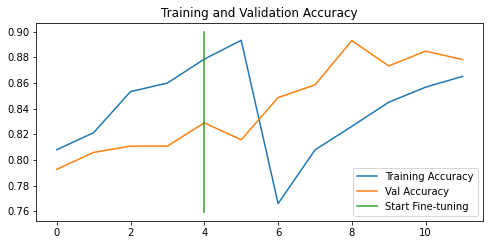

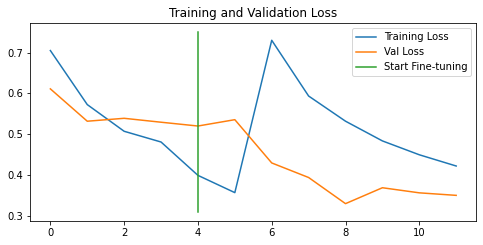

In [ ]:
# How did fine-tuning go with more data?
compare_histories(original_history=history_fine_10_percent_data_aug,new_history=history_fine_10_classes_full)

## Viewing our expriment data on TensorBoard

> 🔑**Note** Anything you upload to TensorBoard.dev is public. So if you have private data, do not upload.

In [ ]:
# View tensorboard logs of transfer learnong modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning --name "Transfer learning experiments with 10 Food101 classes" --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." --one_shot

My tensorboard experiments are available at: https://tensorboard.dev/experiment/aXoVWSAPSGGNir5lQ5h27Q/